This notebook provides:
- A function to parse your string and compare answers, seeing whether they are true or false.
- *Lack-of-instruction-GPT*, a proportion of answers boxed checker to see how well the model followed instructions
- For Wolfram Alpha, proportion of results correct.

Key figures:
- Performance comparisons between baseline-davinci, baseline-turbo, fine-tuned davinci, wolfram-davinci, wolfram-turbo, wolfram-finetuned-davinci. Also, breakdown by levels.
- Explanation for poor performance of fine-tuned models through examples
- Lack-of-instruction GPT
- Out of the answers boxed, re-evaluated performance comparisons. Breakdown by levels.
- For Wolfram Alpha, proportion of calls that failed
- Out of successful calls, re-evaluated performance comparisons. Breakdown by levels.

### Helper function to parse strings & compare answers

Use ```answer_match``` to compare answers. True if same. False if different.
Use ```box_checker``` to see if the model boxed its answer.

In [5]:
# ANSWER_MATCH & box_checker HELPER FUNCTIONS

import os
import json
from sympy import *
from sympy.parsing.latex import parse_latex
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Helper function to find the index of the matching closing brace for the first opening brace
def find_matching_brace(text):
    count = 0
    for i, c in enumerate(text):
        if c == "{":
            count += 1
        elif c == "}":
            count -= 1
            if count == 0:
                return i
    return -1

# Function to extract the contents of a boxed section that follows a search string
def answerextracter(s1,s2,search_string): # s1 = ai answer, s2 = not ai answer

    # Find the position of the search string in s1
    start_pos_ai = s1.find(search_string)
    if start_pos_ai != -1: # if found
        # Add the length of the search string to get the starting position of the boxed section
        value_start_ai = start_pos_ai + len(search_string)
        # Find the end position of the value by searching for the end of the boxed section
        value_end_ai = find_matching_brace(s1[value_start_ai:len(s1)])
        # If the end position of the value was not found, set it to the end of the file
        if value_end_ai == -1:
            value_end_ai = len(s1)
        # Extract the value from the file contents
        ai_ans = s1[value_start_ai:(value_start_ai+value_end_ai)]
    else:
        ai_ans = s1

    # Find the position of the search string
    start_pos_not_ai = s2.find(search_string)
    if start_pos_not_ai != -1: # if found
        # Add the length of the search string to get the starting position of the boxed section
        value_start_not_ai = start_pos_not_ai + len(search_string)
        # Find the end position of the boxed section by searching for the next brace
        value_end_not_ai = find_matching_brace(s2[value_start_not_ai:len(s2)])
        # If the end position of the boxed section was not found, set it to the end of the file
        if value_end_not_ai == -1:
            value_end_not_ai = len(s2)
        # Extract the boxed section from the file contents
        not_ai_ans=s2[value_start_not_ai:(value_start_not_ai+value_end_not_ai)]
    else:
        not_ai_ans = s2

    # Replace certain LaTeX codes with their equivalent symbols
    ai_ans= ai_ans[1:].replace("\$","").replace("{,}",",").replace("\!","") .replace("dfrac","frac")
    not_ai_ans= not_ai_ans[1:].replace("\$","").replace("\!","") .replace("dfrac","frac")

    return str(ai_ans),str(not_ai_ans)

# Will remove any text that's found within each answer
def prunetext(s1,s2):
    # Find the position of the 'text' string in s1 --> will be in LaTeX
    s2_pos_ai = s1.find('text')
    # Find the position of the 'text' string in s2 --> will be in LaTeX
    s2_pos_not_ai = s2.find('text')

    # If the 'text' string was found in s1
    if s2_pos_ai != -1:
        # Add the length of the 'text' string to get the starting position of the boxed section
        v_start_ai = s2_pos_ai + len('text')
        # Find the end position of the boxed section by searching for the end of the boxed section
        v_end_ai = find_matching_brace(s1[v_start_ai:len(s1)])
        # If the end position of the boxed section was not found, set it to the end of the file
        if v_end_ai == -1:
            v_end_ai = len(s1)
            # Remove the boxed section from s1
            ai_ans2 = s1[0:s2_pos_ai] + s1[v_start_ai + v_end_ai + 1:len(s1)]
            # print(s1[s2_pos_ai:v_start_ai + v_end_ai + 1])
        if v_end_ai != -1:
            # Extract the boxed section from s1
            # print(s1[s2_pos_ai:v_start_ai + v_end_ai + 1])
            ai_ans2 = s1[0:s2_pos_ai] + s1[v_start_ai + v_end_ai + 1:len(s1)]
    else:
        # If the 'text' string was not found in s1, set ai_ans2 to s1
        ai_ans2 = s1
      
    # If the 'text' string was found in s2
    if s2_pos_not_ai != -1:
        # Add the length of the 'text' string to get the starting position of the boxed section
        v_start_not_ai = s2_pos_not_ai + len('text')
        # Find the end position of the boxed section by searching for the next brace 
        v_end_not_ai = find_matching_brace(s2[v_start_not_ai:len(s2)])
        # If the end position of the boxed section was not found, set it to the end of the file
        if v_end_not_ai == -1:
            v_end_not_ai = len(s2)
            # Remove the boxed section from s2
            not_ai_ans2 = s2[0:s2_pos_not_ai] + s2[v_start_not_ai + v_end_not_ai + 1:len(s2)]
        if v_end_not_ai != -1:
            # Extract the boxed section from s2
            not_ai_ans2 = s2[0:s2_pos_not_ai] + s2[v_start_not_ai + v_end_not_ai + 1:len(s2)]
    else:
        # If the 'text' string was not found in s2, set not_ai_ans2 to s2
        not_ai_ans2 = s2

    return(ai_ans2,not_ai_ans2)

# CHECK NUMBER 3
def sympycheck(s1,s2): ##s1 is ai, s2 is not ai
    try: 
        exp_ai = parse_latex(s1)
        exp_not_ai = parse_latex(s2)
        sim1 = sympify(exp_ai).evalf()
        sim2 = sympify(exp_not_ai).evalf()
        if sim1==sim2:
            return(True)
        else:
            return(False)
    except:
        return(False)

In [6]:
# FUNCTION CHECKER
def answer_match(s1,s2):
    """
    true = same
    false = different
    """
    search_string = "boxed"
    s1new,s2new=answerextracter(s1,s2,search_string)
    s1n,s2n=prunetext(s1new,s2new)
    if s1new == s2new:
        return(True)
    else:
        if sympycheck(s1n,s2n)==True:
            return(True)
        else:
            return(False)

In [7]:
def box_checker(s1):
    """
    returns "boxed" if boxed properly
    returns "nobox" if no box at all
    returns "bracketerror" if it boxed, but there's no end bracket
    """
    search_string = "boxed"

    # Find the position of the search string in s1
    start_pos_ai = s1.find(search_string)

    if start_pos_ai != -1: # if found
        # Add the length of the search string to get the starting position of the boxed section
        value_start_ai = start_pos_ai + len(search_string)
        # Find the end position of the value by searching for the end of the boxed section
        value_end_ai = find_matching_brace(s1[value_start_ai:len(s1)])
        # If the end position of the value was not found, set it to the end of the file
        if value_end_ai == -1:
            return "bracketerror"
        if value_end_ai != -1:
            # Extract the value from the file contents
            return "boxed"
    else:
        return "nobox"
    
box_checker(r"$$\boxed{2}$$")

'boxed'

### Use box-checker to manually label everything in a .json directory

Commented out so I don't accidentally run it every time I "run all" this entire notebook

In [31]:
# def check(folder_path):

#     for data_type in ["test"]:
#         print(data_type)
#         # Loop over the subdirectories in the data directory
#         for sub_dir in os.listdir(os.path.join(folder_path, data_type)):
#                 # Loop over every file in the folder
#                 for filename in os.listdir(os.path.join(folder_path, data_type, sub_dir)):
#                     # Construct the full path to the file
#                     file_path = os.path.join(folder_path, data_type, sub_dir, filename)
#                     # Check that the file is a regular file (not a directory or a special file)
#                     if os.path.isfile(file_path):
#                         # Open the file for reading
#                             with open(file_path, "r") as f:
                            
#                                 # Read the contents of the file
#                                 content = json.load(f)
#                                 ai=content["gptanswer"]
#                                 content["boxed"] = box_checker(ai)
#                                 print(content["boxed"])

#                                 # Save the modified JSON data to a new file
#                                 with open(os.path.join(folder_path, data_type, sub_dir, filename), "w") as file:
#                                     json.dump(content, file)

# print("results-wolfram-turbo")
# check("results-wolfram-turbo/MATH")
# print("results-wolfram-davinci")
# check("results-wolfram-davinci/MATH")
# print("results-finetuned-davinci")
# check("results-finetuned-davinci/MATH")
# print("results-baseline-davinci")
# check("results-baseline-davinci/MATH")
# print("results-baseline-turbo")
# check("results-baseline-turbo/MATH")

# Key Figures

## Figure 1

In [51]:
def check(folder_path):

    #initialize right and wrong
    
    level_right=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5
    level_wrong=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5

    # Loop over the train and test directories
    # for data_type in ["train", "test"]:
    for data_type in ["test"]:

        # Loop over the subdirectories in the data directory
        for sub_dir in os.listdir(os.path.join(folder_path, data_type)):

            right=0
            wrong=0 

            # Loop over every file in the folder
            for filename in os.listdir(os.path.join(folder_path, data_type, sub_dir)):

                # Construct the full path to the file
                file_path = os.path.join(folder_path, data_type, sub_dir, filename)

                # Check that the file is a regular file (not a directory or a special file)
                if os.path.isfile(file_path):
                    # Open the file for reading
                    with open(file_path, "r") as f:
                        
                        # Read the contents of the file
                        content = json.load(f)
                        ai=content["gptanswer"]
                        not_ai=content["solution"]
                        level_text = str(content["level"])
                        level = int(level_text[6])  # Python indexing starts from 0, so 6th index is 5

                        if answer_match(ai,not_ai):
                            right+=1
                            level_right[level]+=1
                        else:
                            wrong+=1
                            level_wrong[level]+=1
            
            print(f"{sub_dir} % CORRECT is {right} / {wrong+right} = {right/(wrong+right)}")
            # print(f"Level 1 % CORRECT is {level_right[1]} / {level_wrong[1]+level_right[1]} = {level_right[1]/(level_wrong[1]+level_right[1])}")
            # print(f"Level 2 % CORRECT is {level_right[2]} / {level_wrong[2]+level_right[2]} = {level_right[2]/(level_wrong[2]+level_right[2])}")
            # print(f"Level 3 % CORRECT is {level_right[3]} / {level_wrong[3]+level_right[3]} = {level_right[3]/(level_wrong[3]+level_right[3])}")

In [52]:
print("baseline-davinci")
check("results-baseline-davinci/MATH")
print("baseline-turbo")
check("results-baseline-turbo/MATH")
print("finetuned-davinci")
check("results-finetuned-davinci/MATH")
print("wolfram-davinci")
check("results-wolfram-davinci/MATH")
print("wolfram-turbo")
check("results-wolfram-turbo/MATH")

baseline-davinci
counting_and_probability % CORRECT is 2 / 30 = 0.06666666666666667
intermediate_algebra % CORRECT is 2 / 30 = 0.06666666666666667
number_theory % CORRECT is 3 / 30 = 0.1
precalculus % CORRECT is 1 / 30 = 0.03333333333333333
prealgebra % CORRECT is 4 / 30 = 0.13333333333333333
geometry % CORRECT is 0 / 30 = 0.0
algebra % CORRECT is 2 / 30 = 0.06666666666666667
baseline-turbo
counting_and_probability % CORRECT is 14 / 30 = 0.4666666666666667
intermediate_algebra % CORRECT is 10 / 30 = 0.3333333333333333
number_theory % CORRECT is 13 / 30 = 0.43333333333333335
precalculus % CORRECT is 8 / 30 = 0.26666666666666666
prealgebra % CORRECT is 20 / 30 = 0.6666666666666666
geometry % CORRECT is 16 / 30 = 0.5333333333333333
algebra % CORRECT is 20 / 30 = 0.6666666666666666
finetuned-davinci
counting_and_probability % CORRECT is 2 / 30 = 0.06666666666666667
intermediate_algebra % CORRECT is 2 / 30 = 0.06666666666666667
number_theory % CORRECT is 0 / 30 = 0.0
precalculus % CORRECT i

Performance comparisons between baseline-davinci, baseline-turbo, fine-tuned davinci, wolfram-davinci, wolfram-turbo, wolfram-finetuned-davinci. Breakdown by categories.

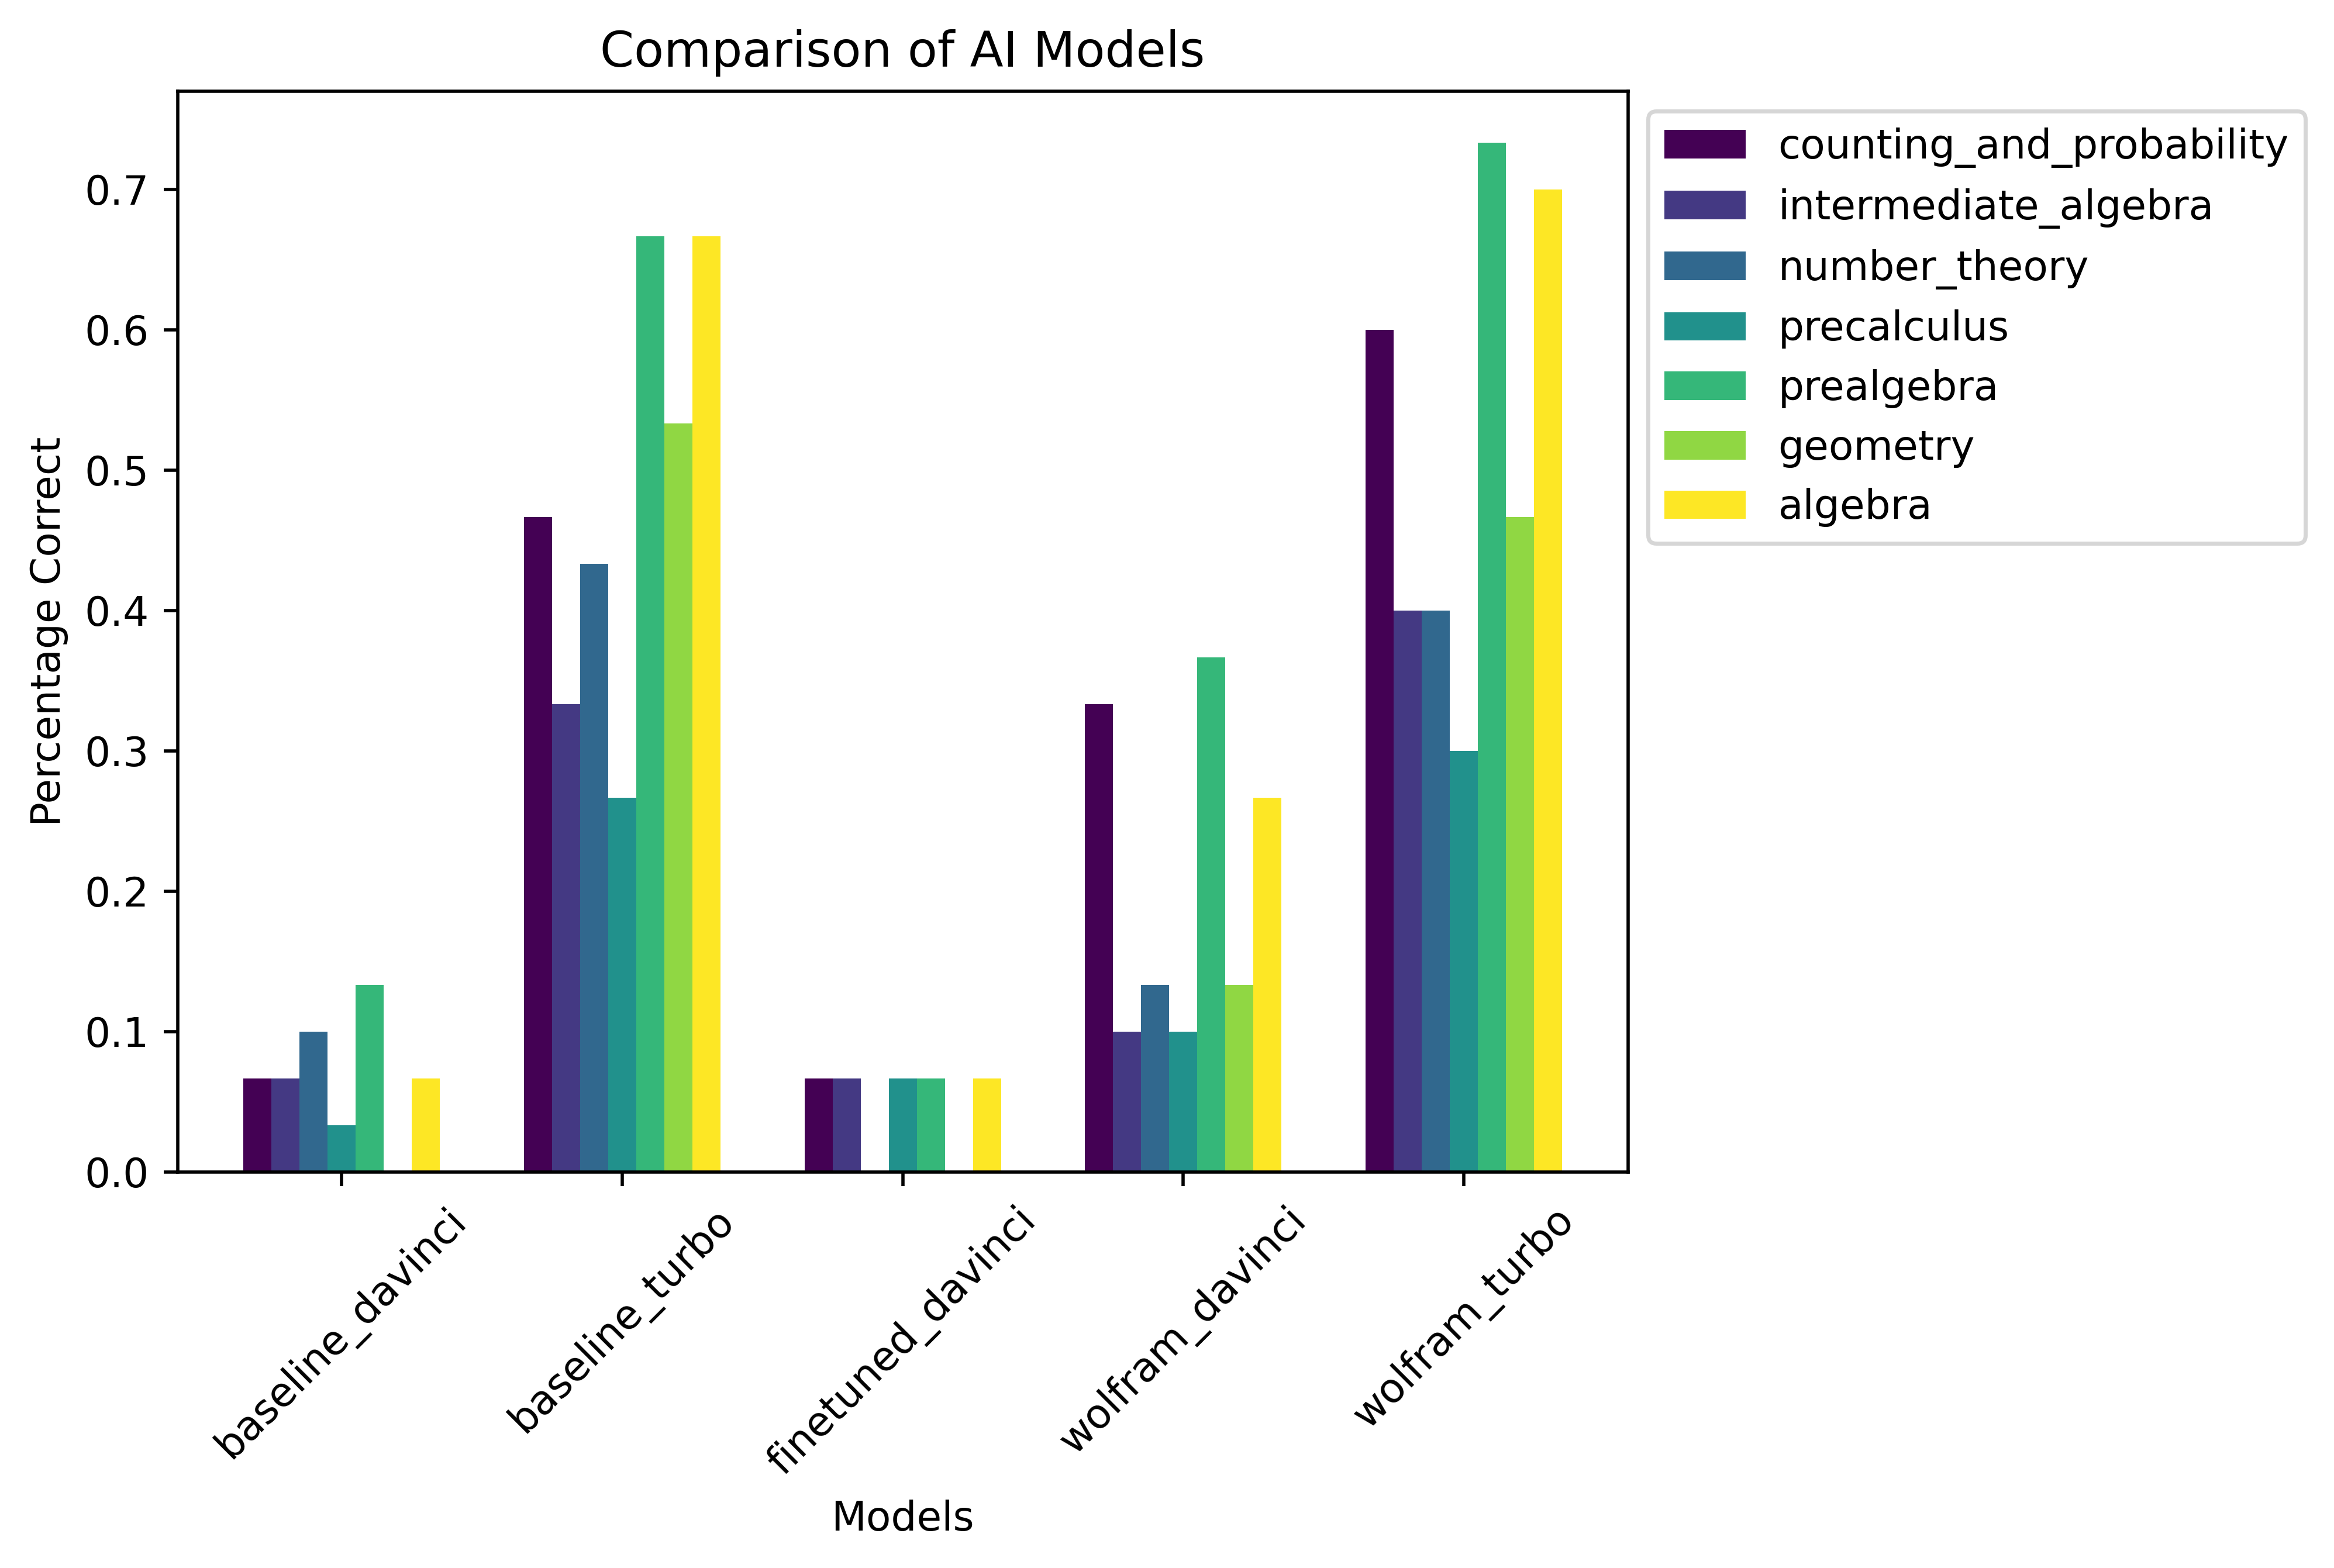

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['baseline_davinci', 'baseline_turbo', 'finetuned_davinci', 'wolfram_davinci', 'wolfram_turbo']

categories = ['counting_and_probability', 'intermediate_algebra', 'number_theory', 'precalculus', 'prealgebra', 'geometry', 'algebra']

data = [
    [0.06666666666666667, 0.06666666666666667, 0.1, 0.03333333333333333, 0.13333333333333333, 0.0, 0.06666666666666667],
    [0.4666666666666667, 0.3333333333333333, 0.43333333333333335, 0.26666666666666666, 0.6666666666666666, 0.5333333333333333, 0.6666666666666666],
    [0.06666666666666667, 0.06666666666666667, 0.0, 0.06666666666666667, 0.06666666666666667, 0.0, 0.06666666666666667],
    [0.3333333333333333, 0.1, 0.13333333333333333, 0.1, 0.36666666666666664, 0.13333333333333333, 0.26666666666666666],
    [0.6, 0.4, 0.4, 0.3, 0.7333333333333333, 0.4666666666666667, 0.7]
]

bar_width = 0.1
x = np.arange(len(models))

fig, ax = plt.subplots(dpi=500)

colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

# Plot the data
for i, (category, color) in enumerate(zip(categories, colors)):
    ax.bar(x + i * bar_width, [row[i] for row in data], bar_width, label=category, color=color)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Percentage Correct')
ax.set_title('Comparison of AI Models')
ax.set_xticks(x + (bar_width * (len(categories) - 1) / 2))
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the chart
plt.show()


## Figure 2

In [15]:
import os
def check(folder_path):

    #initialize right and wrong
    right=0
    wrong=0 
    level_right=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5
    level_wrong=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5

    # Loop over the train and test directories
    # for data_type in ["train", "test"]:
    for data_type in ["test"]:

        # Loop over the subdirectories in the data directory
        for sub_dir in os.listdir(os.path.join(folder_path, data_type)):

            # Loop over every file in the folder
            for filename in os.listdir(os.path.join(folder_path, data_type, sub_dir)):

                # Construct the full path to the file
                file_path = os.path.join(folder_path, data_type, sub_dir, filename)

                # Check that the file is a regular file (not a directory or a special file)
                if os.path.isfile(file_path):
                    # Open the file for reading
                    with open(file_path, "r") as f:
                        
                        # Read the contents of the file
                        content = json.load(f)
                        ai=content["gptanswer"]
                        not_ai=content["solution"]
                        level_text = str(content["level"])
                        level = int(level_text[6])  # Python indexing starts from 0, so 6th index is 5

                        if answer_match(ai,not_ai):
                            right+=1
                            level_right[level]+=1
                        else:
                            wrong+=1
                            level_wrong[level]+=1

        print(f"Level 1 % CORRECT is {level_right[1]} / {level_wrong[1]+level_right[1]} = {level_right[1]/(level_wrong[1]+level_right[1])}")
        print(f"Level 2 % CORRECT is {level_right[2]} / {level_wrong[2]+level_right[2]} = {level_right[2]/(level_wrong[2]+level_right[2])}")
        print(f"Level 3 % CORRECT is {level_right[3]} / {level_wrong[3]+level_right[3]} = {level_right[3]/(level_wrong[3]+level_right[3])}")

In [16]:
print("baseline-davinci")
check("results-baseline-davinci/MATH")
print("baseline-turbo")
check("results-baseline-turbo/MATH")
print("finetuned-davinci")
check("results-finetuned-davinci/MATH")
print("wolfram-davinci")
check("results-wolfram-davinci/MATH")
print("wolfram-turbo")
check("results-wolfram-turbo/MATH")

baseline-davinci
Level 1 % CORRECT is 6 / 70 = 0.08571428571428572
Level 2 % CORRECT is 6 / 70 = 0.08571428571428572
Level 3 % CORRECT is 2 / 70 = 0.02857142857142857
baseline-turbo
Level 1 % CORRECT is 42 / 70 = 0.6
Level 2 % CORRECT is 33 / 70 = 0.4714285714285714
Level 3 % CORRECT is 26 / 70 = 0.37142857142857144
finetuned-davinci
Level 1 % CORRECT is 4 / 70 = 0.05714285714285714
Level 2 % CORRECT is 5 / 70 = 0.07142857142857142
Level 3 % CORRECT is 1 / 70 = 0.014285714285714285
wolfram-davinci
Level 1 % CORRECT is 26 / 70 = 0.37142857142857144
Level 2 % CORRECT is 10 / 70 = 0.14285714285714285
Level 3 % CORRECT is 7 / 70 = 0.1
wolfram-turbo
Level 1 % CORRECT is 47 / 70 = 0.6714285714285714
Level 2 % CORRECT is 37 / 70 = 0.5285714285714286
Level 3 % CORRECT is 24 / 70 = 0.34285714285714286


Performance comparisons between baseline-davinci, baseline-turbo, fine-tuned davinci, wolfram-davinci, wolfram-turbo, wolfram-finetuned-davinci. Breakdown by levels (level 1, level 2, level 3).

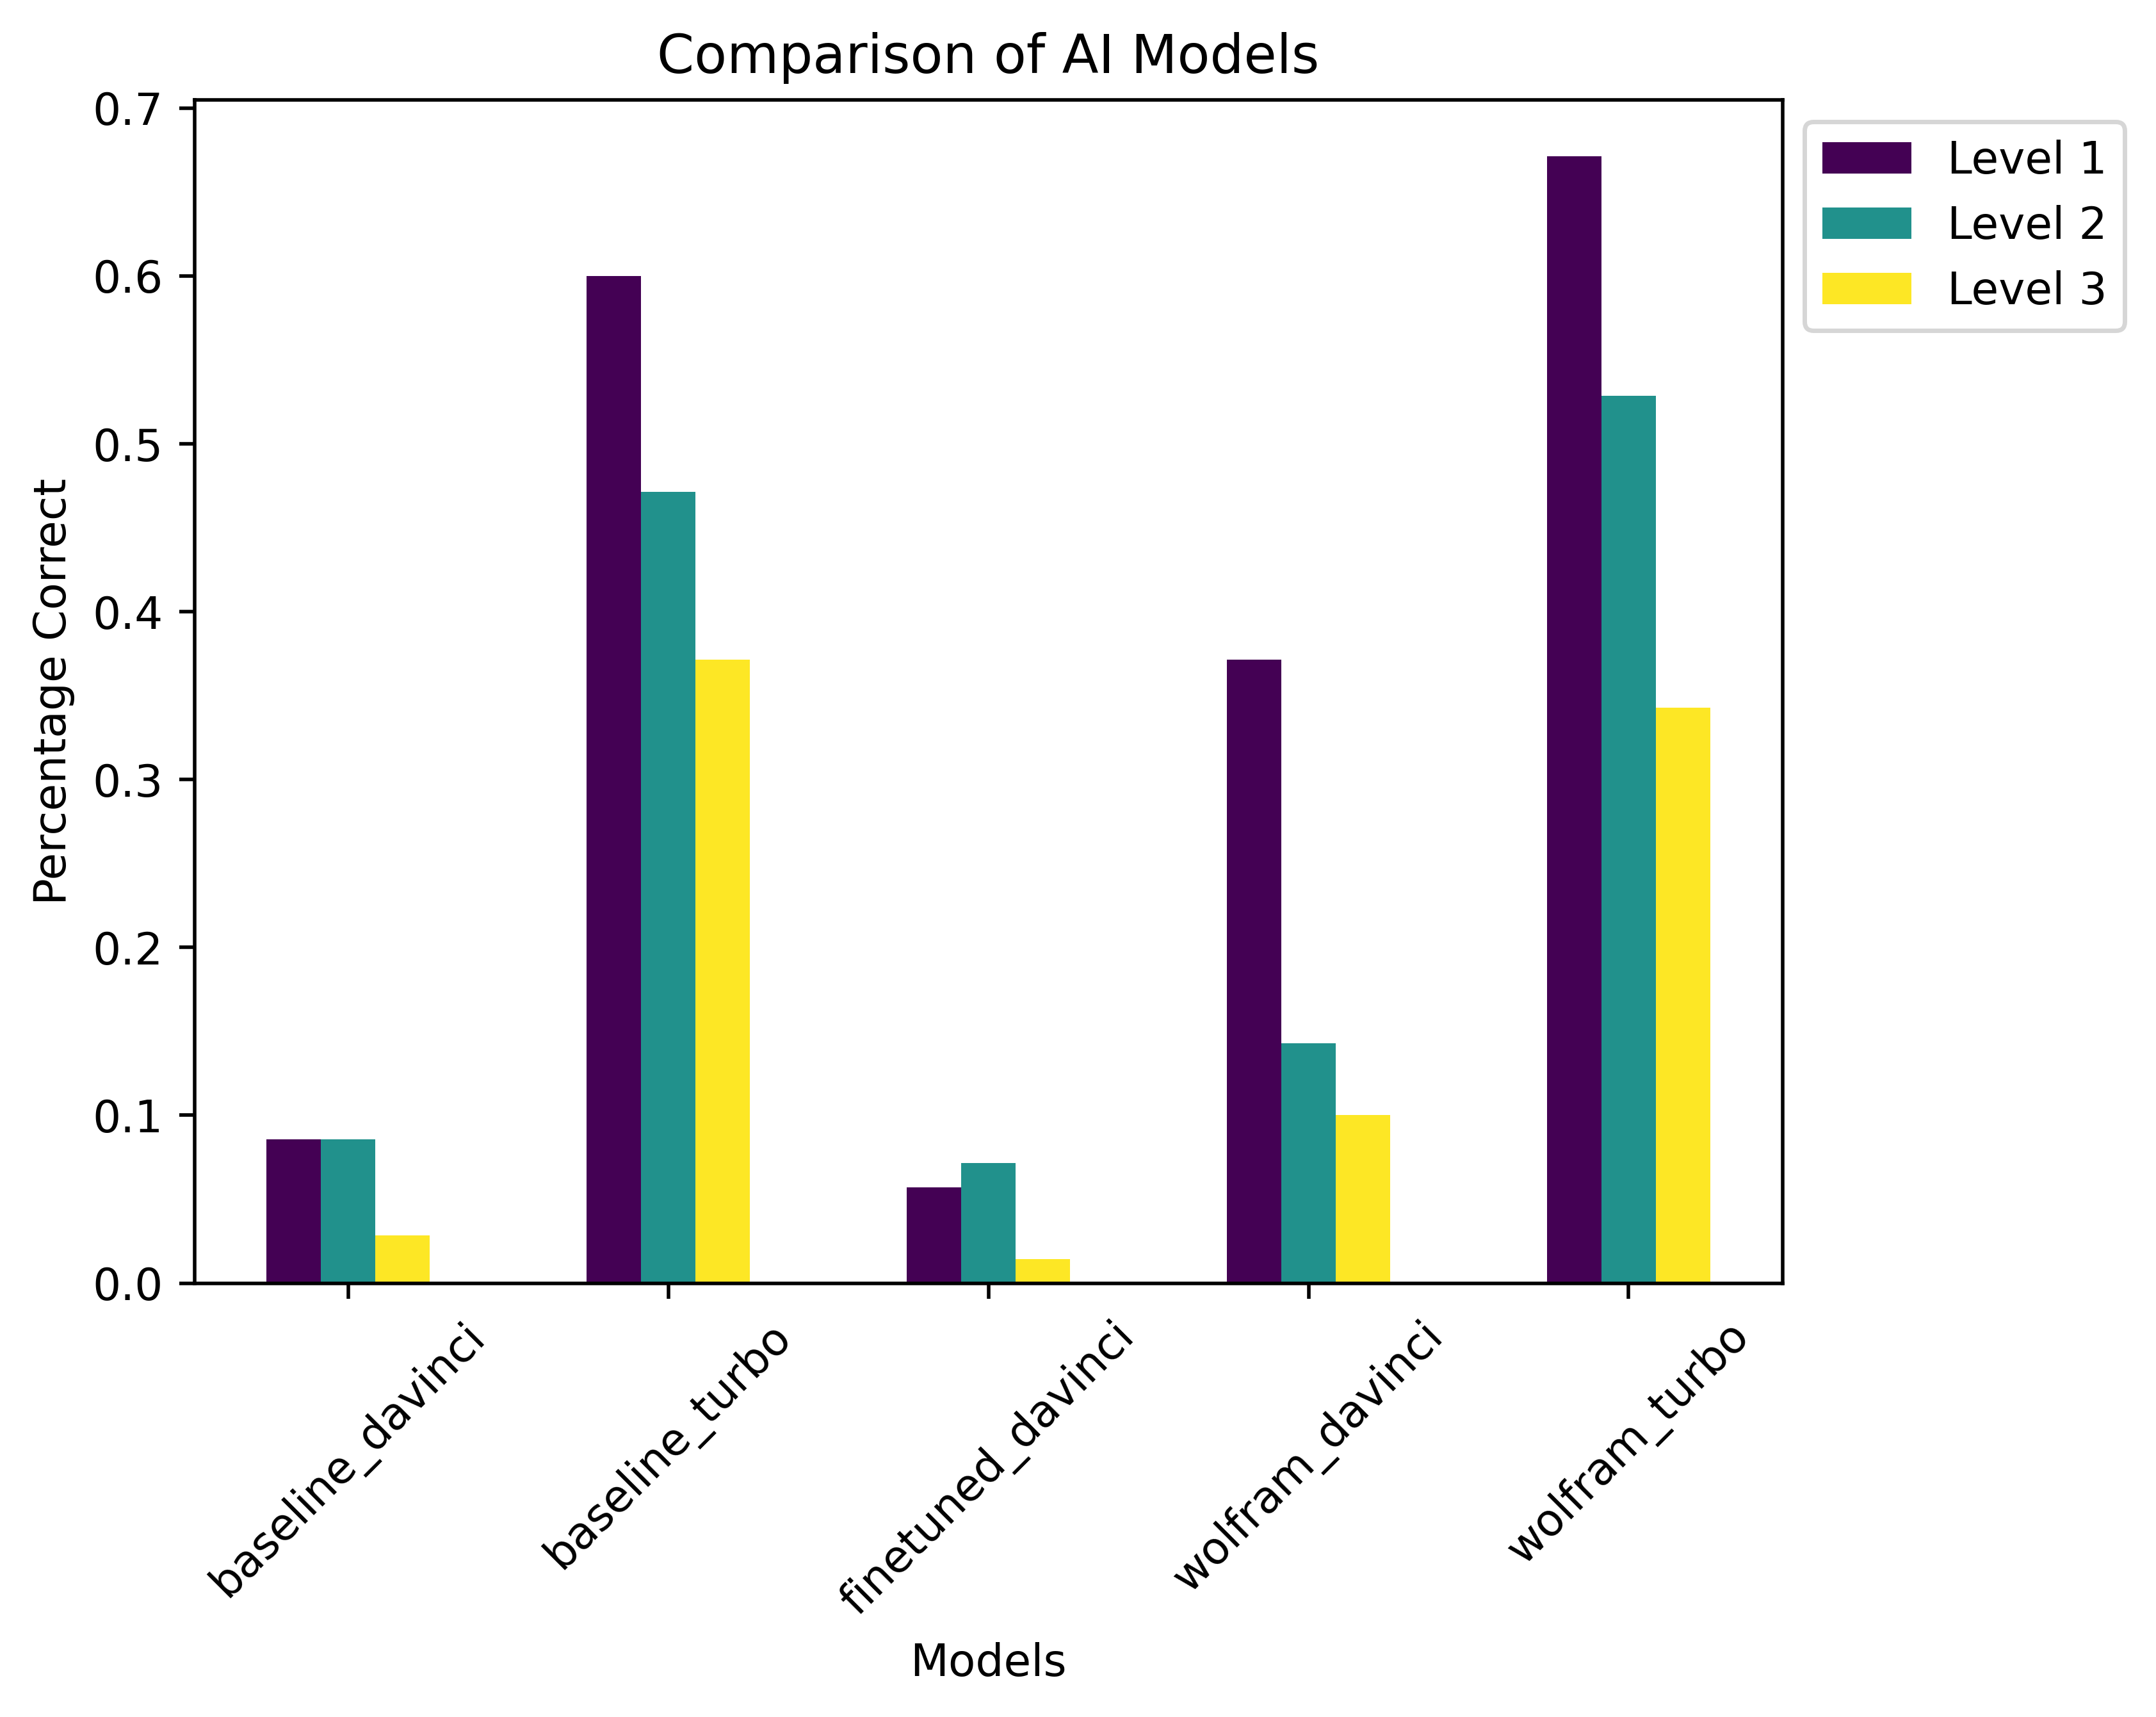

In [29]:
import matplotlib.pyplot as plt

# Data
models = ['baseline_davinci', 'baseline_turbo', 'finetuned_davinci', 'wolfram_davinci', 'wolfram_turbo']

categories = ['Level 1', 'Level 2', 'Level 3']

data = [
    [0.08571428571428572, 0.08571428571428572, 0.02857142857142857],
    [0.6, 0.4714285714285714, 0.37142857142857144],
    [0.05714285714285714, 0.07142857142857142, 0.014285714285714285],
    [0.37142857142857144, 0.14285714285714285, 0.1],
    [0.6714285714285714, 0.5285714285714286, 0.34285714285714286]
]

bar_width = 0.17
x = np.arange(len(models))

fig, ax = plt.subplots(dpi=500)

colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

# Plot the data
for i, (category, color) in enumerate(zip(categories, colors)):
    ax.bar(x + i * bar_width, [row[i] for row in data], bar_width, label=category, color=color)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Percentage Correct')
ax.set_title('Comparison of AI Models')
ax.set_xticks(x + (bar_width * (len(categories) - 1) / 2))
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the chart
plt.show()

## Figure 3

Proportion of answers boxed between all models.

In [23]:
import os
def check(folder_path):

    #initialize right and wrong
    boxed_right=0
    boxed_wrongish=0
    boxed_wrong=0 

    # Loop over the train and test directories
    # for data_type in ["train", "test"]:
    for data_type in ["test"]:

        # Loop over the subdirectories in the data directory
        for sub_dir in os.listdir(os.path.join(folder_path, data_type)):

            # Loop over every file in the folder
            for filename in os.listdir(os.path.join(folder_path, data_type, sub_dir)):

                # Construct the full path to the file
                file_path = os.path.join(folder_path, data_type, sub_dir, filename)

                # Check that the file is a regular file (not a directory or a special file)
                if os.path.isfile(file_path):
                    # Open the file for reading
                    with open(file_path, "r") as f:
                        
                        # Read the contents of the file
                        content = json.load(f)
                        ai=content["gptanswer"]
                        not_ai=content["solution"]
                        boxed = content["boxed"]
                        if boxed == "boxed":
                            boxed_right+=1
                        elif boxed == "nobox":  
                            boxed_wrong+=1
                        else: #boxed == "bracketerror"
                            boxed_wrongish+=1

        print("boxed:", boxed_right)
        print("nobox:", boxed_wrong)
        print("nobracket:", boxed_wrongish)

In [24]:
print("baseline-davinci")
check("results-baseline-davinci/MATH")
print("baseline-turbo")
check("results-baseline-turbo/MATH")
print("finetuned-davinci")
check("results-finetuned-davinci/MATH")
print("wolfram-davinci")
check("results-wolfram-davinci/MATH")
print("wolfram-turbo")
check("results-wolfram-turbo/MATH")

baseline-davinci
boxed: 200
nobox: 10
nobracket: 0
baseline-turbo
boxed: 210
nobox: 0
nobracket: 0
finetuned-davinci
boxed: 154
nobox: 53
nobracket: 3
wolfram-davinci
boxed: 187
nobox: 23
nobracket: 0
wolfram-turbo
boxed: 208
nobox: 2
nobracket: 0


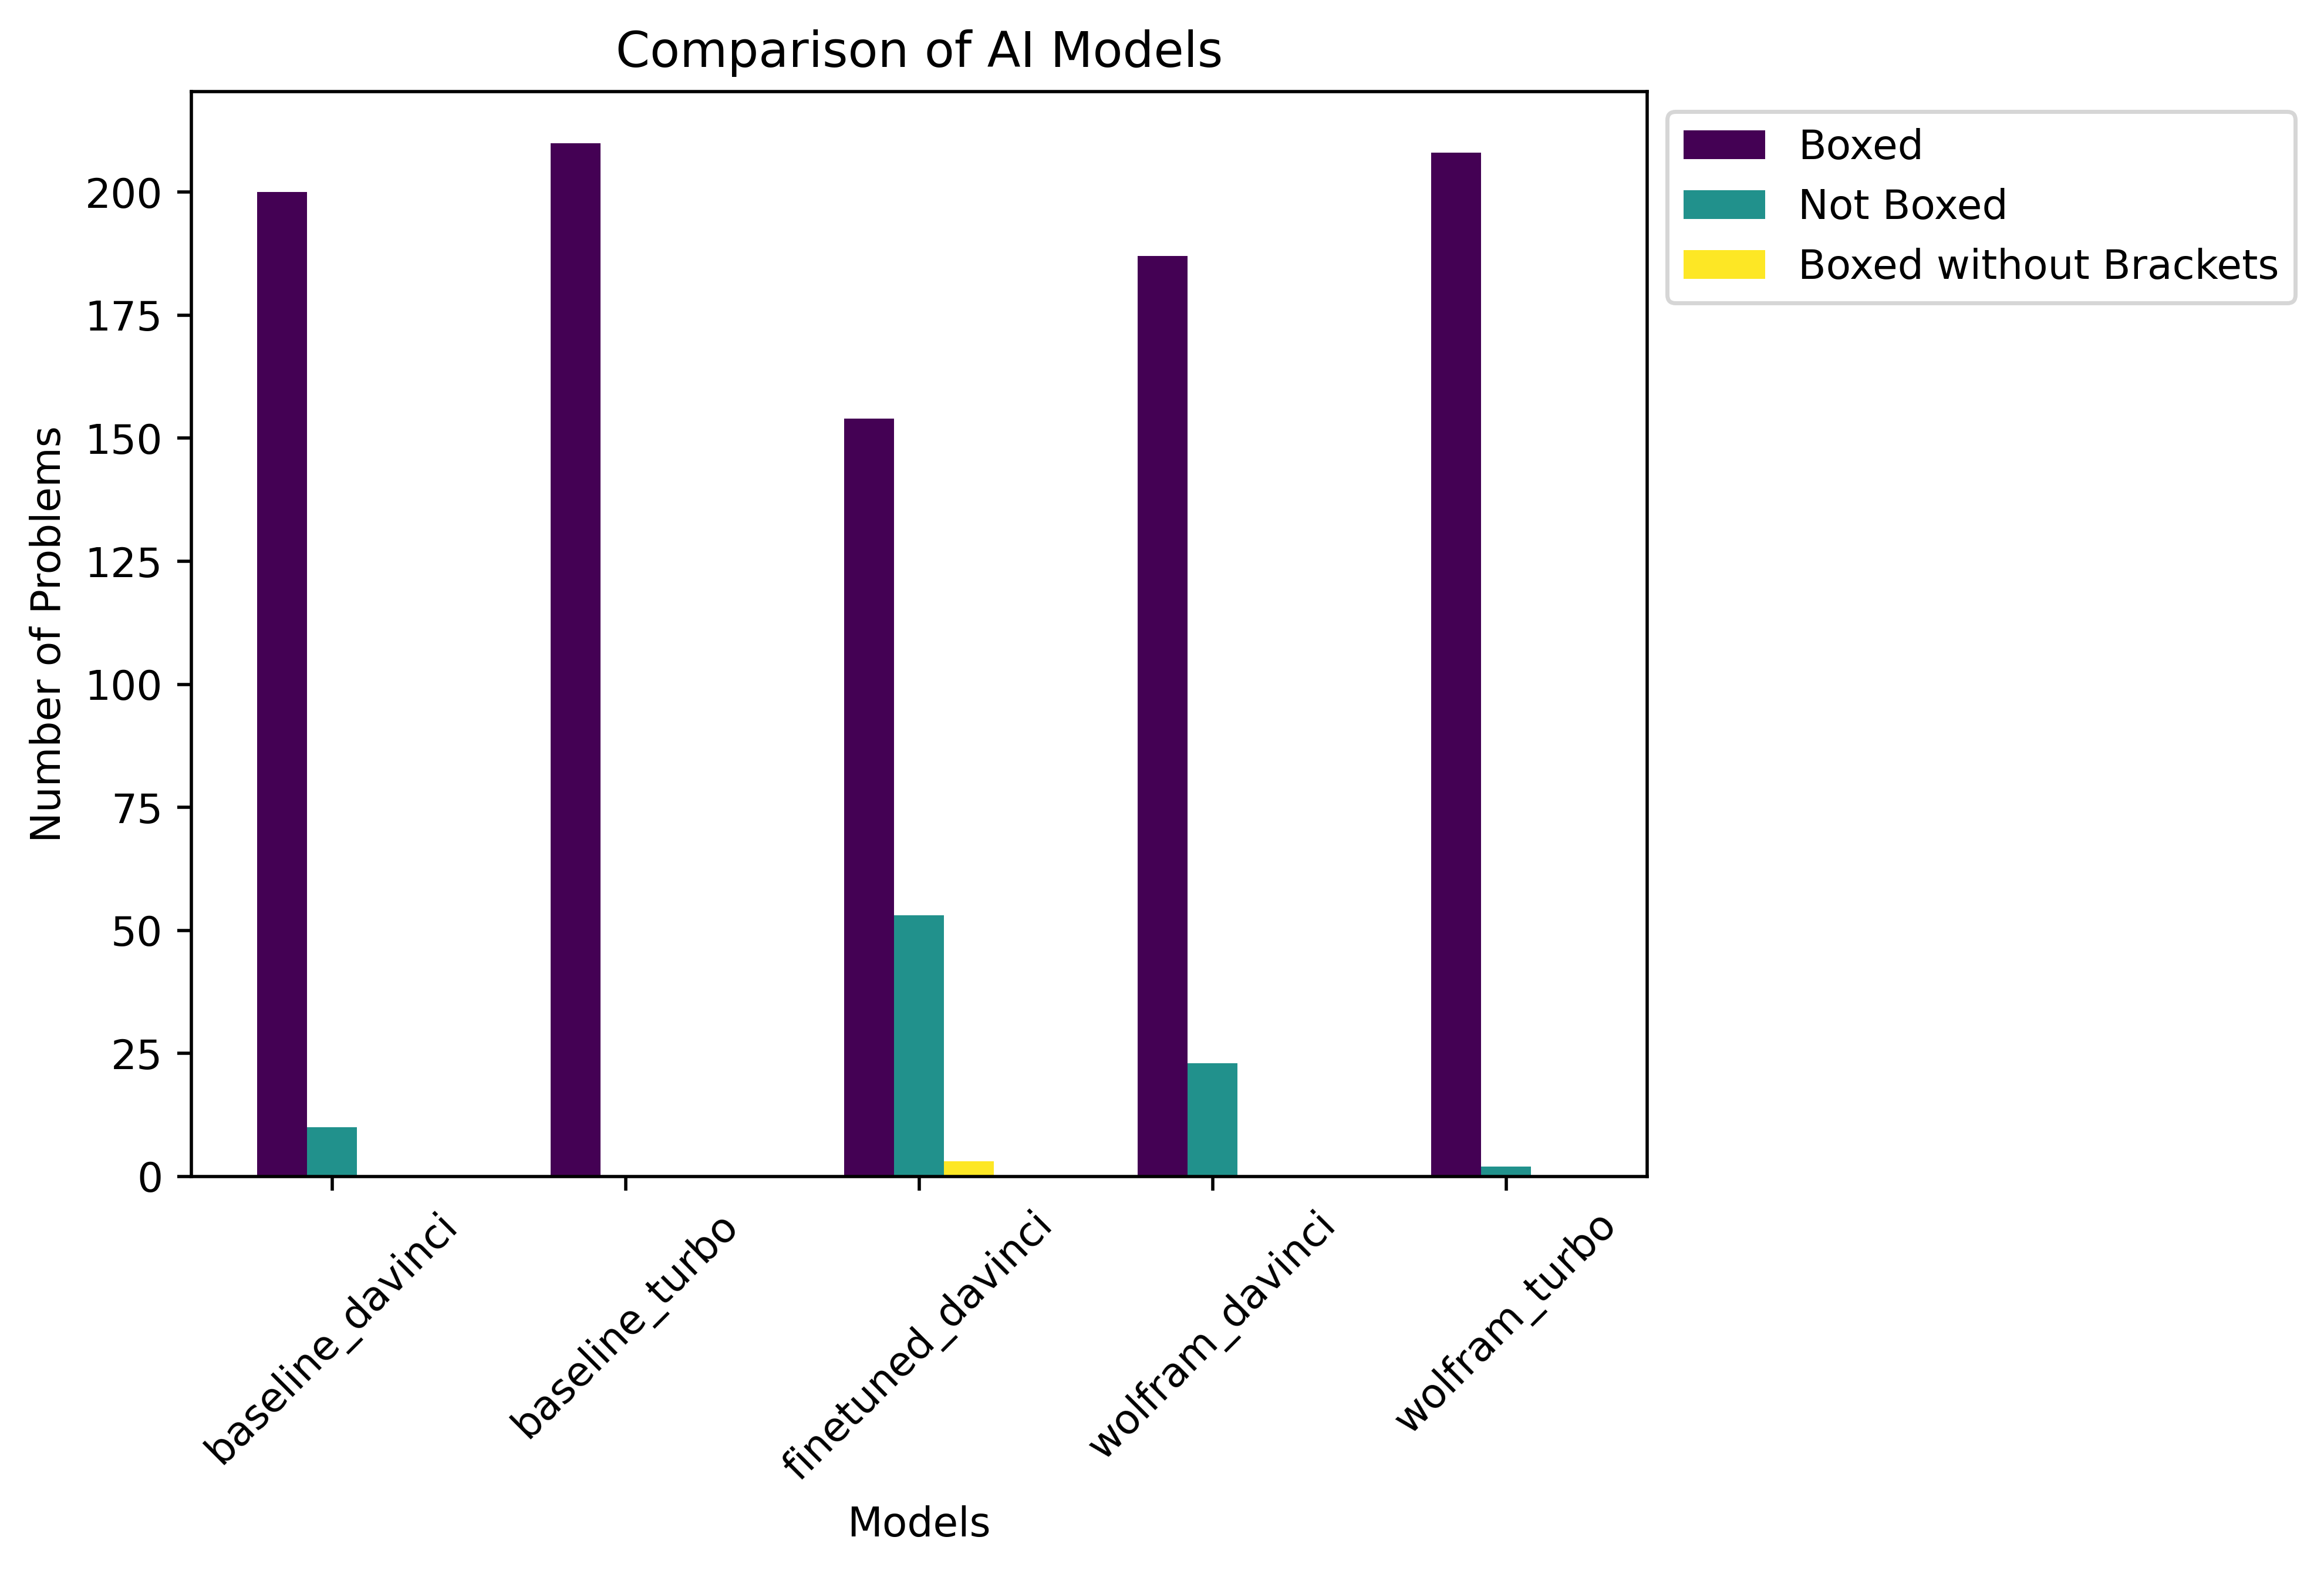

In [30]:
data = [
    [200, 10, 0],
    [210, 0, 0],
    [154, 53, 3],
    [187, 23, 0],
    [208, 2, 0]
]

import matplotlib.pyplot as plt

# Data
models = ['baseline_davinci', 'baseline_turbo', 'finetuned_davinci', 'wolfram_davinci', 'wolfram_turbo']

categories = ['Boxed', 'Not Boxed', 'Boxed without Brackets']

bar_width = 0.17
x = np.arange(len(models))

fig, ax = plt.subplots(dpi=500)

colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

# Plot the data
for i, (category, color) in enumerate(zip(categories, colors)):
    ax.bar(x + i * bar_width, [row[i] for row in data], bar_width, label=category, color=color)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Number of Problems')
ax.set_title('Comparison of AI Models')
ax.set_xticks(x + (bar_width * (len(categories) - 1) / 2))
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the chart
plt.show()

Proportion of calls that failed.

In [42]:
import os
def check(folder_path):

    #initialize right and wrong
    failed_calls=[0,0,0,0,0,0,0]
    successful_calls=[0,0,0,0,0,0,0]
    i = 0

    # Loop over the train and test directories
    # for data_type in ["train", "test"]:
    for data_type in ["test"]:

        # Loop over the subdirectories in the data directory
        for sub_dir in os.listdir(os.path.join(folder_path, data_type)):

            # Loop over every file in the folder
            for filename in os.listdir(os.path.join(folder_path, data_type, sub_dir)):

                # Construct the full path to the file
                file_path = os.path.join(folder_path, data_type, sub_dir, filename)

                # Check that the file is a regular file (not a directory or a special file)
                if os.path.isfile(file_path):
                    # Open the file for reading
                    with open(file_path, "r") as f:
                        
                        # Read the contents of the file
                        content = json.load(f)
                        wolframoutput=content["wolframoutput"]
                        if wolframoutput == "Wolfram Alpha could not find an answer and encountered an error.":
                            failed_calls[i]+=1
                        else:
                            successful_calls[i]+=1

            print(f"{sub_dir}:", (successful_calls[i]/(successful_calls[i] + failed_calls[i])))
            i+=1

print("wolfram-davinci")
check("results-wolfram-davinci/MATH")
print("wolfram-turbo")
check("results-wolfram-turbo/MATH")

wolfram-davinci
counting_and_probability: 0.7666666666666667
intermediate_algebra: 0.7333333333333333
number_theory: 0.7666666666666667
precalculus: 0.4666666666666667
prealgebra: 0.7666666666666667
geometry: 0.6333333333333333
algebra: 0.9
wolfram-turbo
counting_and_probability: 0.6
intermediate_algebra: 0.5333333333333333
number_theory: 0.43333333333333335
precalculus: 0.6
prealgebra: 0.7666666666666667
geometry: 0.16666666666666666
algebra: 0.5


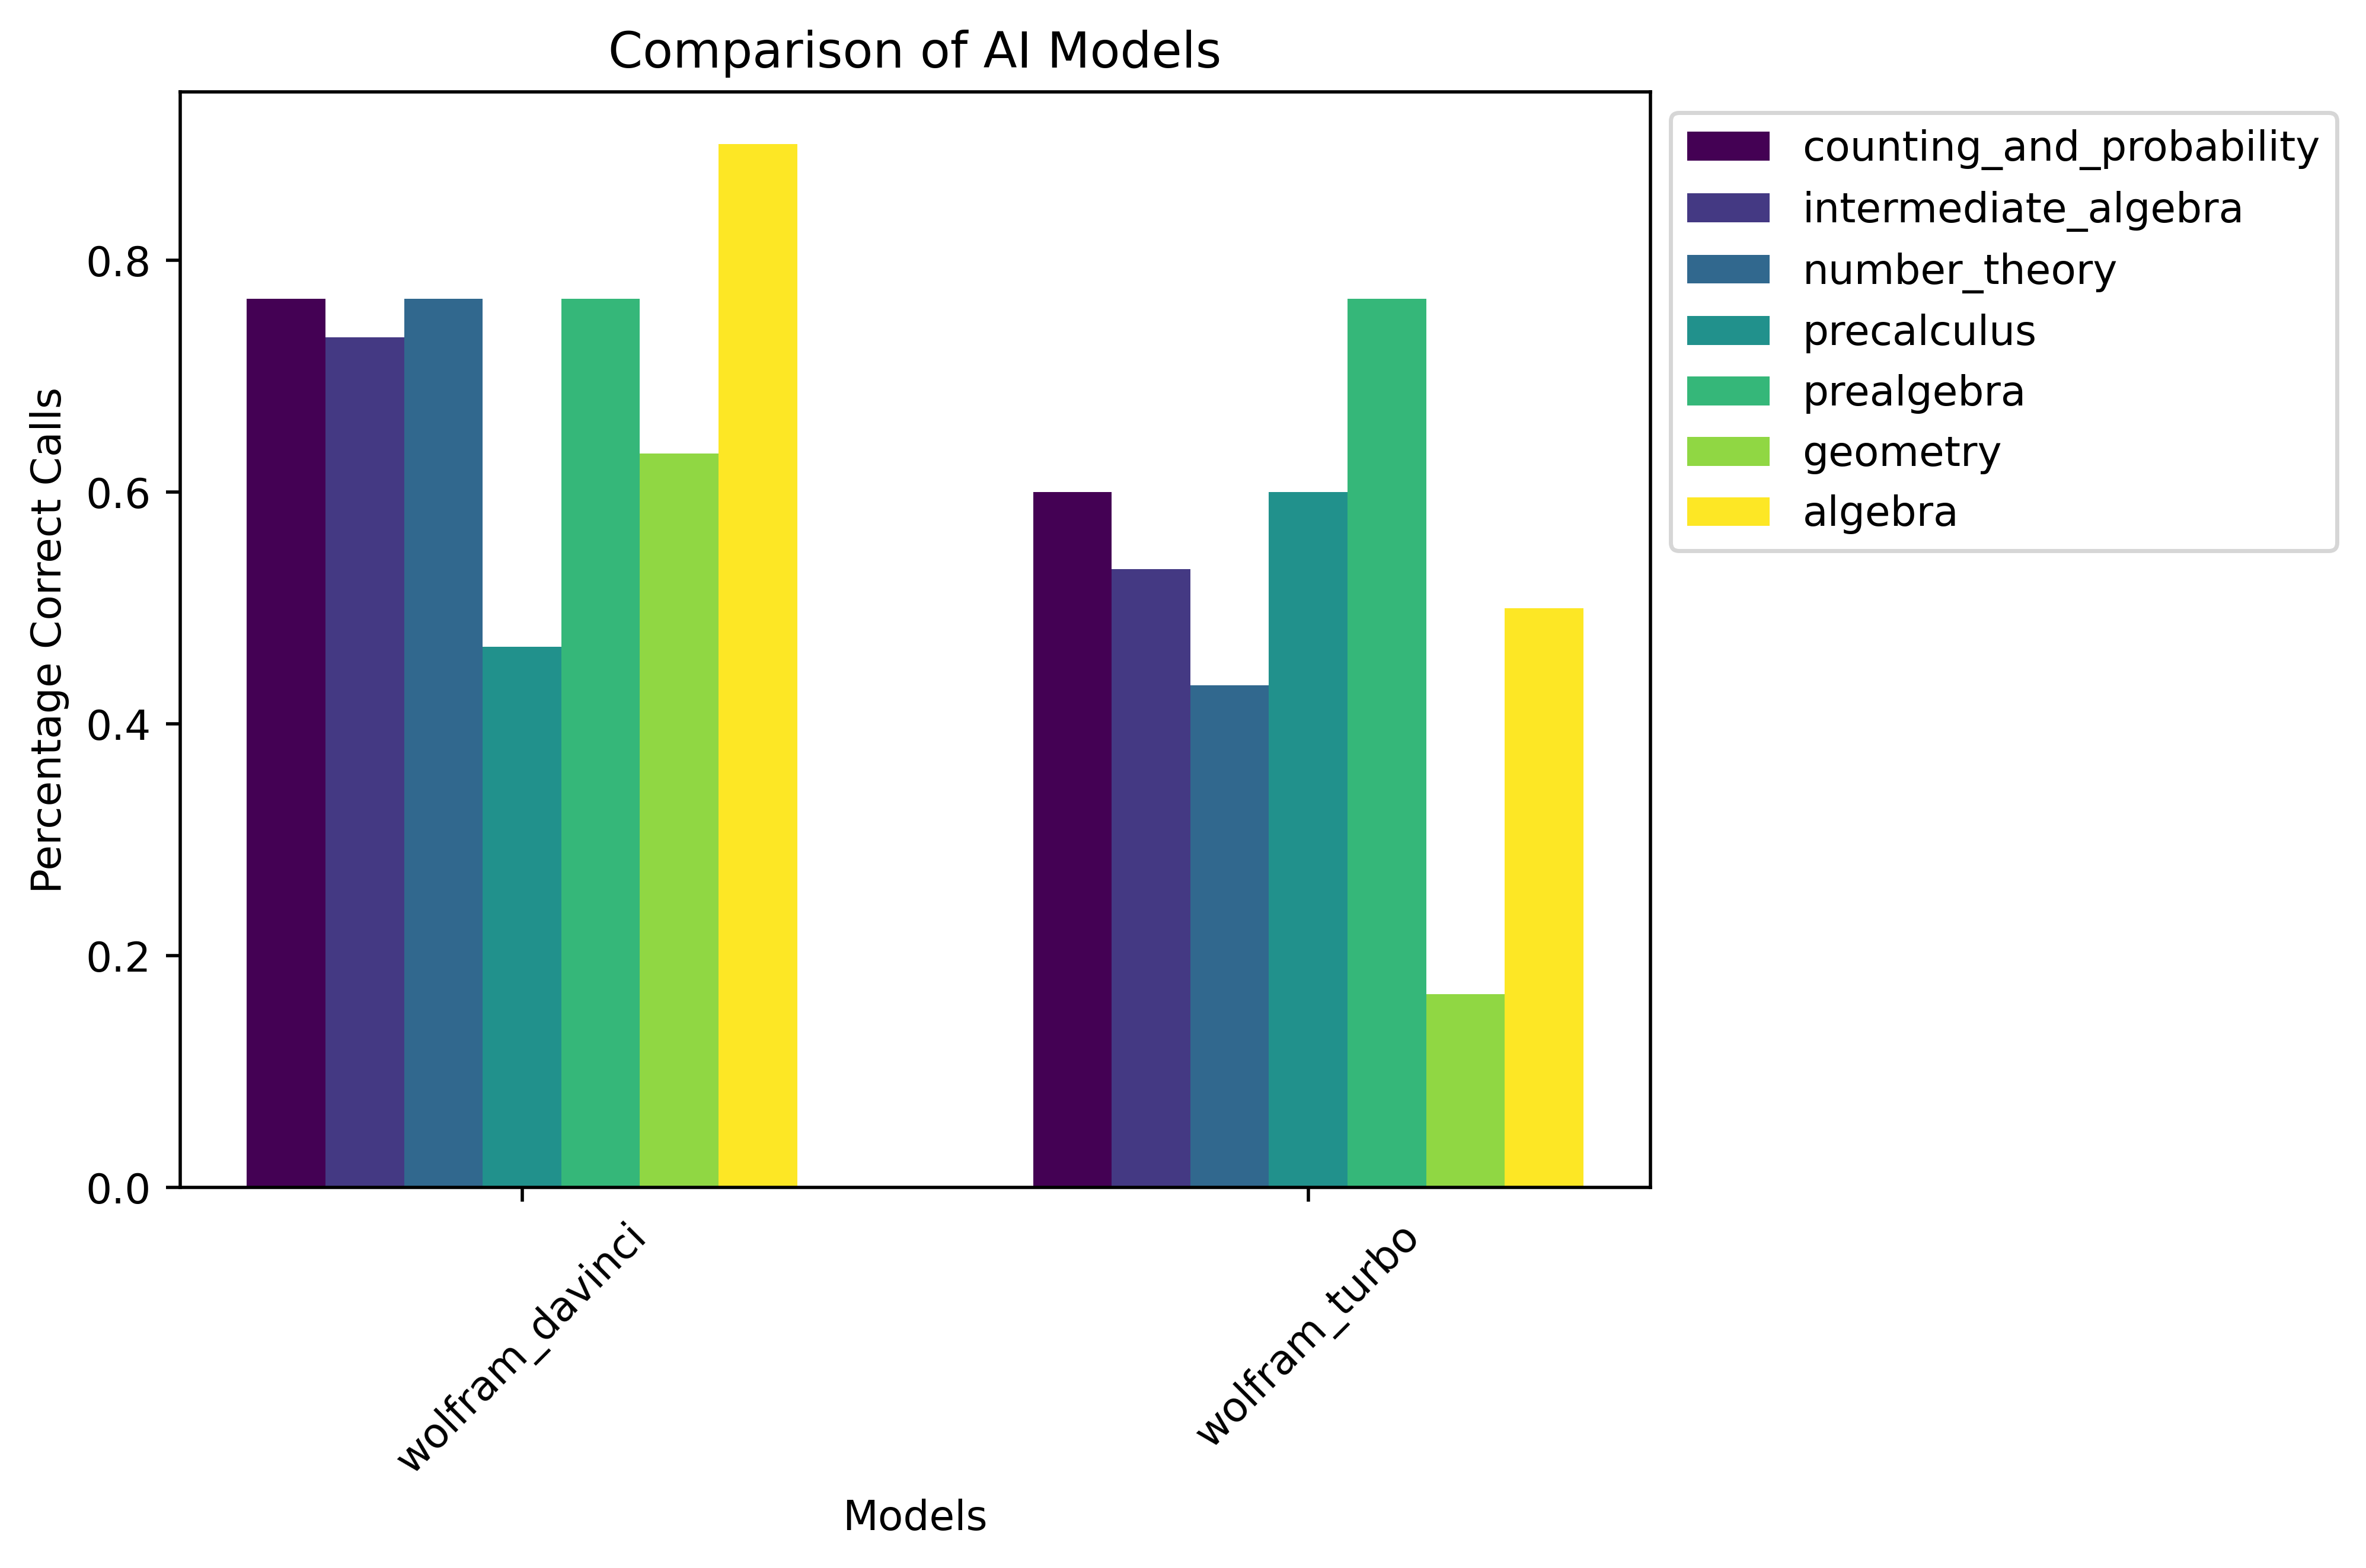

In [48]:
data = [
    [0.7666666666666667, 0.7333333333333333, 0.7666666666666667, 0.4666666666666667, 0.7666666666666667, 0.6333333333333333, 0.9],
    [0.6, 0.5333333333333333, 0.43333333333333335, 0.6, 0.7666666666666667, 0.16666666666666666, 0.5]
]

import matplotlib.pyplot as plt

# Data
models = ['wolfram_davinci', 'wolfram_turbo']

categories = ['counting_and_probability', 'intermediate_algebra', 'number_theory', 'precalculus', 'prealgebra', 'geometry', 'algebra']

bar_width = 0.1
x = np.arange(len(models))

fig, ax = plt.subplots(dpi=500)

colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

# Plot the data
for i, (category, color) in enumerate(zip(categories, colors)):
    ax.bar(x + i * bar_width, [row[i] for row in data], bar_width, label=category, color=color)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Percentage Correct Calls')
ax.set_title('Comparison of AI Models')
ax.set_xticks(x + (bar_width * (len(categories) - 1) / 2))
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the chart
plt.show()

Breakdown by categories & levels, removing all failed calls & box failures.

In [63]:
import os
def check(folder_path):

    level_right=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5
    level_wrong=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5

    # Loop over the train and test directories
    # for data_type in ["train", "test"]:
    for data_type in ["test"]:

        #initialize right and wrong
        right=0
        wrong=0 

        # Loop over the subdirectories in the data directory
        for sub_dir in os.listdir(os.path.join(folder_path, data_type)):

            # Loop over every file in the folder
            for filename in os.listdir(os.path.join(folder_path, data_type, sub_dir)):

                # Construct the full path to the file
                file_path = os.path.join(folder_path, data_type, sub_dir, filename)

                # Check that the file is a regular file (not a directory or a special file)
                if os.path.isfile(file_path):
                    # Open the file for reading
                    with open(file_path, "r") as f:
                        
                        # Read the contents of the file
                        content = json.load(f)
                        ai=content["gptanswer"]
                        not_ai=content["solution"]
                        level_text = str(content["level"])
                        level = int(level_text[6])  # Python indexing starts from 0, so 6th index is 5

                        if 'wolframoutput' in content:
                            # Do something with the 'wolframalpha' field
                            wolframoutput = content['wolframoutput']
                            if wolframoutput == "Wolfram Alpha could not find an answer and encountered an error.":
                                continue
                            else:
                                boxed = content["boxed"]
                                if boxed == "nobox" or boxed == "bracketerror":  
                                    continue
                                if answer_match(ai,not_ai):
                                    right+=1
                                    level_right[level]+=1
                                else:
                                    wrong+=1
                                    level_wrong[level]+=1
                        else:
                            boxed = content["boxed"]
                            if boxed == "nobox" or boxed == "bracketerror":  
                                continue
                            if answer_match(ai,not_ai):
                                right+=1
                                level_right[level]+=1
                            else:
                                wrong+=1
                                level_wrong[level]+=1

            print(f"{sub_dir} % CORRECT is {right} / {wrong+right} = {right/(wrong+right+0.01)}")
            # print(f"Level 1 % CORRECT is {level_right[1]} / {level_wrong[1]+level_right[1]} = {level_right[1]/(level_wrong[1]+level_right[1])}")
            # print(f"Level 2 % CORRECT is {level_right[2]} / {level_wrong[2]+level_right[2]} = {level_right[2]/(level_wrong[2]+level_right[2])}")
            # print(f"Level 3 % CORRECT is {level_right[3]} / {level_wrong[3]+level_right[3]} = {level_right[3]/(level_wrong[3]+level_right[3])}")

print("baseline-davinci")
check("results-baseline-davinci/MATH")
print("baseline-turbo")
check("results-baseline-turbo/MATH")
print("finetuned-davinci")
check("results-finetuned-davinci/MATH")
print("wolfram-davinci")
check("results-wolfram-davinci/MATH")
print("wolfram-turbo")
check("results-wolfram-turbo/MATH")

baseline-davinci
counting_and_probability % CORRECT is 2 / 27 = 0.07404664938911514
intermediate_algebra % CORRECT is 4 / 55 = 0.07271405199054717
number_theory % CORRECT is 7 / 84 = 0.08332341387930008
precalculus % CORRECT is 8 / 113 = 0.07079019555791523
prealgebra % CORRECT is 12 / 141 = 0.0851003474930856
geometry % CORRECT is 12 / 170 = 0.07058408328921828
algebra % CORRECT is 14 / 200 = 0.06999650017499125
baseline-turbo
counting_and_probability % CORRECT is 14 / 30 = 0.46651116294568473
intermediate_algebra % CORRECT is 24 / 60 = 0.39993334444259293
number_theory % CORRECT is 37 / 90 = 0.41106543717364735
precalculus % CORRECT is 45 / 120 = 0.37496875260394963
prealgebra % CORRECT is 65 / 150 = 0.433304446370242
geometry % CORRECT is 81 / 180 = 0.44997500138881175
algebra % CORRECT is 101 / 210 = 0.48092947954859294
finetuned-davinci
counting_and_probability % CORRECT is 2 / 24 = 0.08329862557267805
intermediate_algebra % CORRECT is 4 / 48 = 0.08331597583836702
number_theory % 

In [66]:
import os
def check(folder_path):

    level_right=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5
    level_wrong=[0, 0, 0, 0, 0, 0] # levels 0, 1, 2, 3, 4, 5

    # Loop over the train and test directories
    # for data_type in ["train", "test"]:
    for data_type in ["test"]:

        #initialize right and wrong
        right=0
        wrong=0 

        # Loop over the subdirectories in the data directory
        for sub_dir in os.listdir(os.path.join(folder_path, data_type)):

            # Loop over every file in the folder
            for filename in os.listdir(os.path.join(folder_path, data_type, sub_dir)):

                # Construct the full path to the file
                file_path = os.path.join(folder_path, data_type, sub_dir, filename)

                # Check that the file is a regular file (not a directory or a special file)
                if os.path.isfile(file_path):
                    # Open the file for reading
                    with open(file_path, "r") as f:
                        
                        # Read the contents of the file
                        content = json.load(f)
                        ai=content["gptanswer"]
                        not_ai=content["solution"]
                        level_text = str(content["level"])
                        level = int(level_text[6])  # Python indexing starts from 0, so 6th index is 5

                        if 'wolframoutput' in content:
                            # Do something with the 'wolframalpha' field
                            wolframoutput = content['wolframoutput']
                            if wolframoutput == "Wolfram Alpha could not find an answer and encountered an error.":
                                continue
                            else:
                                boxed = content["boxed"]
                                if boxed == "nobox" or boxed == "bracketerror":  
                                    continue
                                if answer_match(ai,not_ai):
                                    right+=1
                                    level_right[level]+=1
                                else:
                                    wrong+=1
                                    level_wrong[level]+=1
                        else:
                            boxed = content["boxed"]
                            if boxed == "nobox" or boxed == "bracketerror":  
                                continue
                            if answer_match(ai,not_ai):
                                right+=1
                                level_right[level]+=1
                            else:
                                wrong+=1
                                level_wrong[level]+=1

        print(f"Level 1 % CORRECT is {level_right[1]} / {level_wrong[1]+level_right[1]} = {level_right[1]/(level_wrong[1]+level_right[1])}")
        print(f"Level 2 % CORRECT is {level_right[2]} / {level_wrong[2]+level_right[2]} = {level_right[2]/(level_wrong[2]+level_right[2])}")
        print(f"Level 3 % CORRECT is {level_right[3]} / {level_wrong[3]+level_right[3]} = {level_right[3]/(level_wrong[3]+level_right[3])}")

print("baseline-davinci")
check("results-baseline-davinci/MATH")
print("baseline-turbo")
check("results-baseline-turbo/MATH")
print("finetuned-davinci")
check("results-finetuned-davinci/MATH")
print("wolfram-davinci")
check("results-wolfram-davinci/MATH")
print("wolfram-turbo")
check("results-wolfram-turbo/MATH")

baseline-davinci
Level 1 % CORRECT is 6 / 67 = 0.08955223880597014
Level 2 % CORRECT is 6 / 67 = 0.08955223880597014
Level 3 % CORRECT is 2 / 66 = 0.030303030303030304
baseline-turbo
Level 1 % CORRECT is 42 / 70 = 0.6
Level 2 % CORRECT is 33 / 70 = 0.4714285714285714
Level 3 % CORRECT is 26 / 70 = 0.37142857142857144
finetuned-davinci
Level 1 % CORRECT is 4 / 49 = 0.08163265306122448
Level 2 % CORRECT is 5 / 53 = 0.09433962264150944
Level 3 % CORRECT is 1 / 52 = 0.019230769230769232
wolfram-davinci
Level 1 % CORRECT is 25 / 56 = 0.44642857142857145
Level 2 % CORRECT is 10 / 48 = 0.20833333333333334
Level 3 % CORRECT is 7 / 36 = 0.19444444444444445
wolfram-turbo
Level 1 % CORRECT is 31 / 46 = 0.6739130434782609
Level 2 % CORRECT is 19 / 35 = 0.5428571428571428
Level 3 % CORRECT is 14 / 26 = 0.5384615384615384


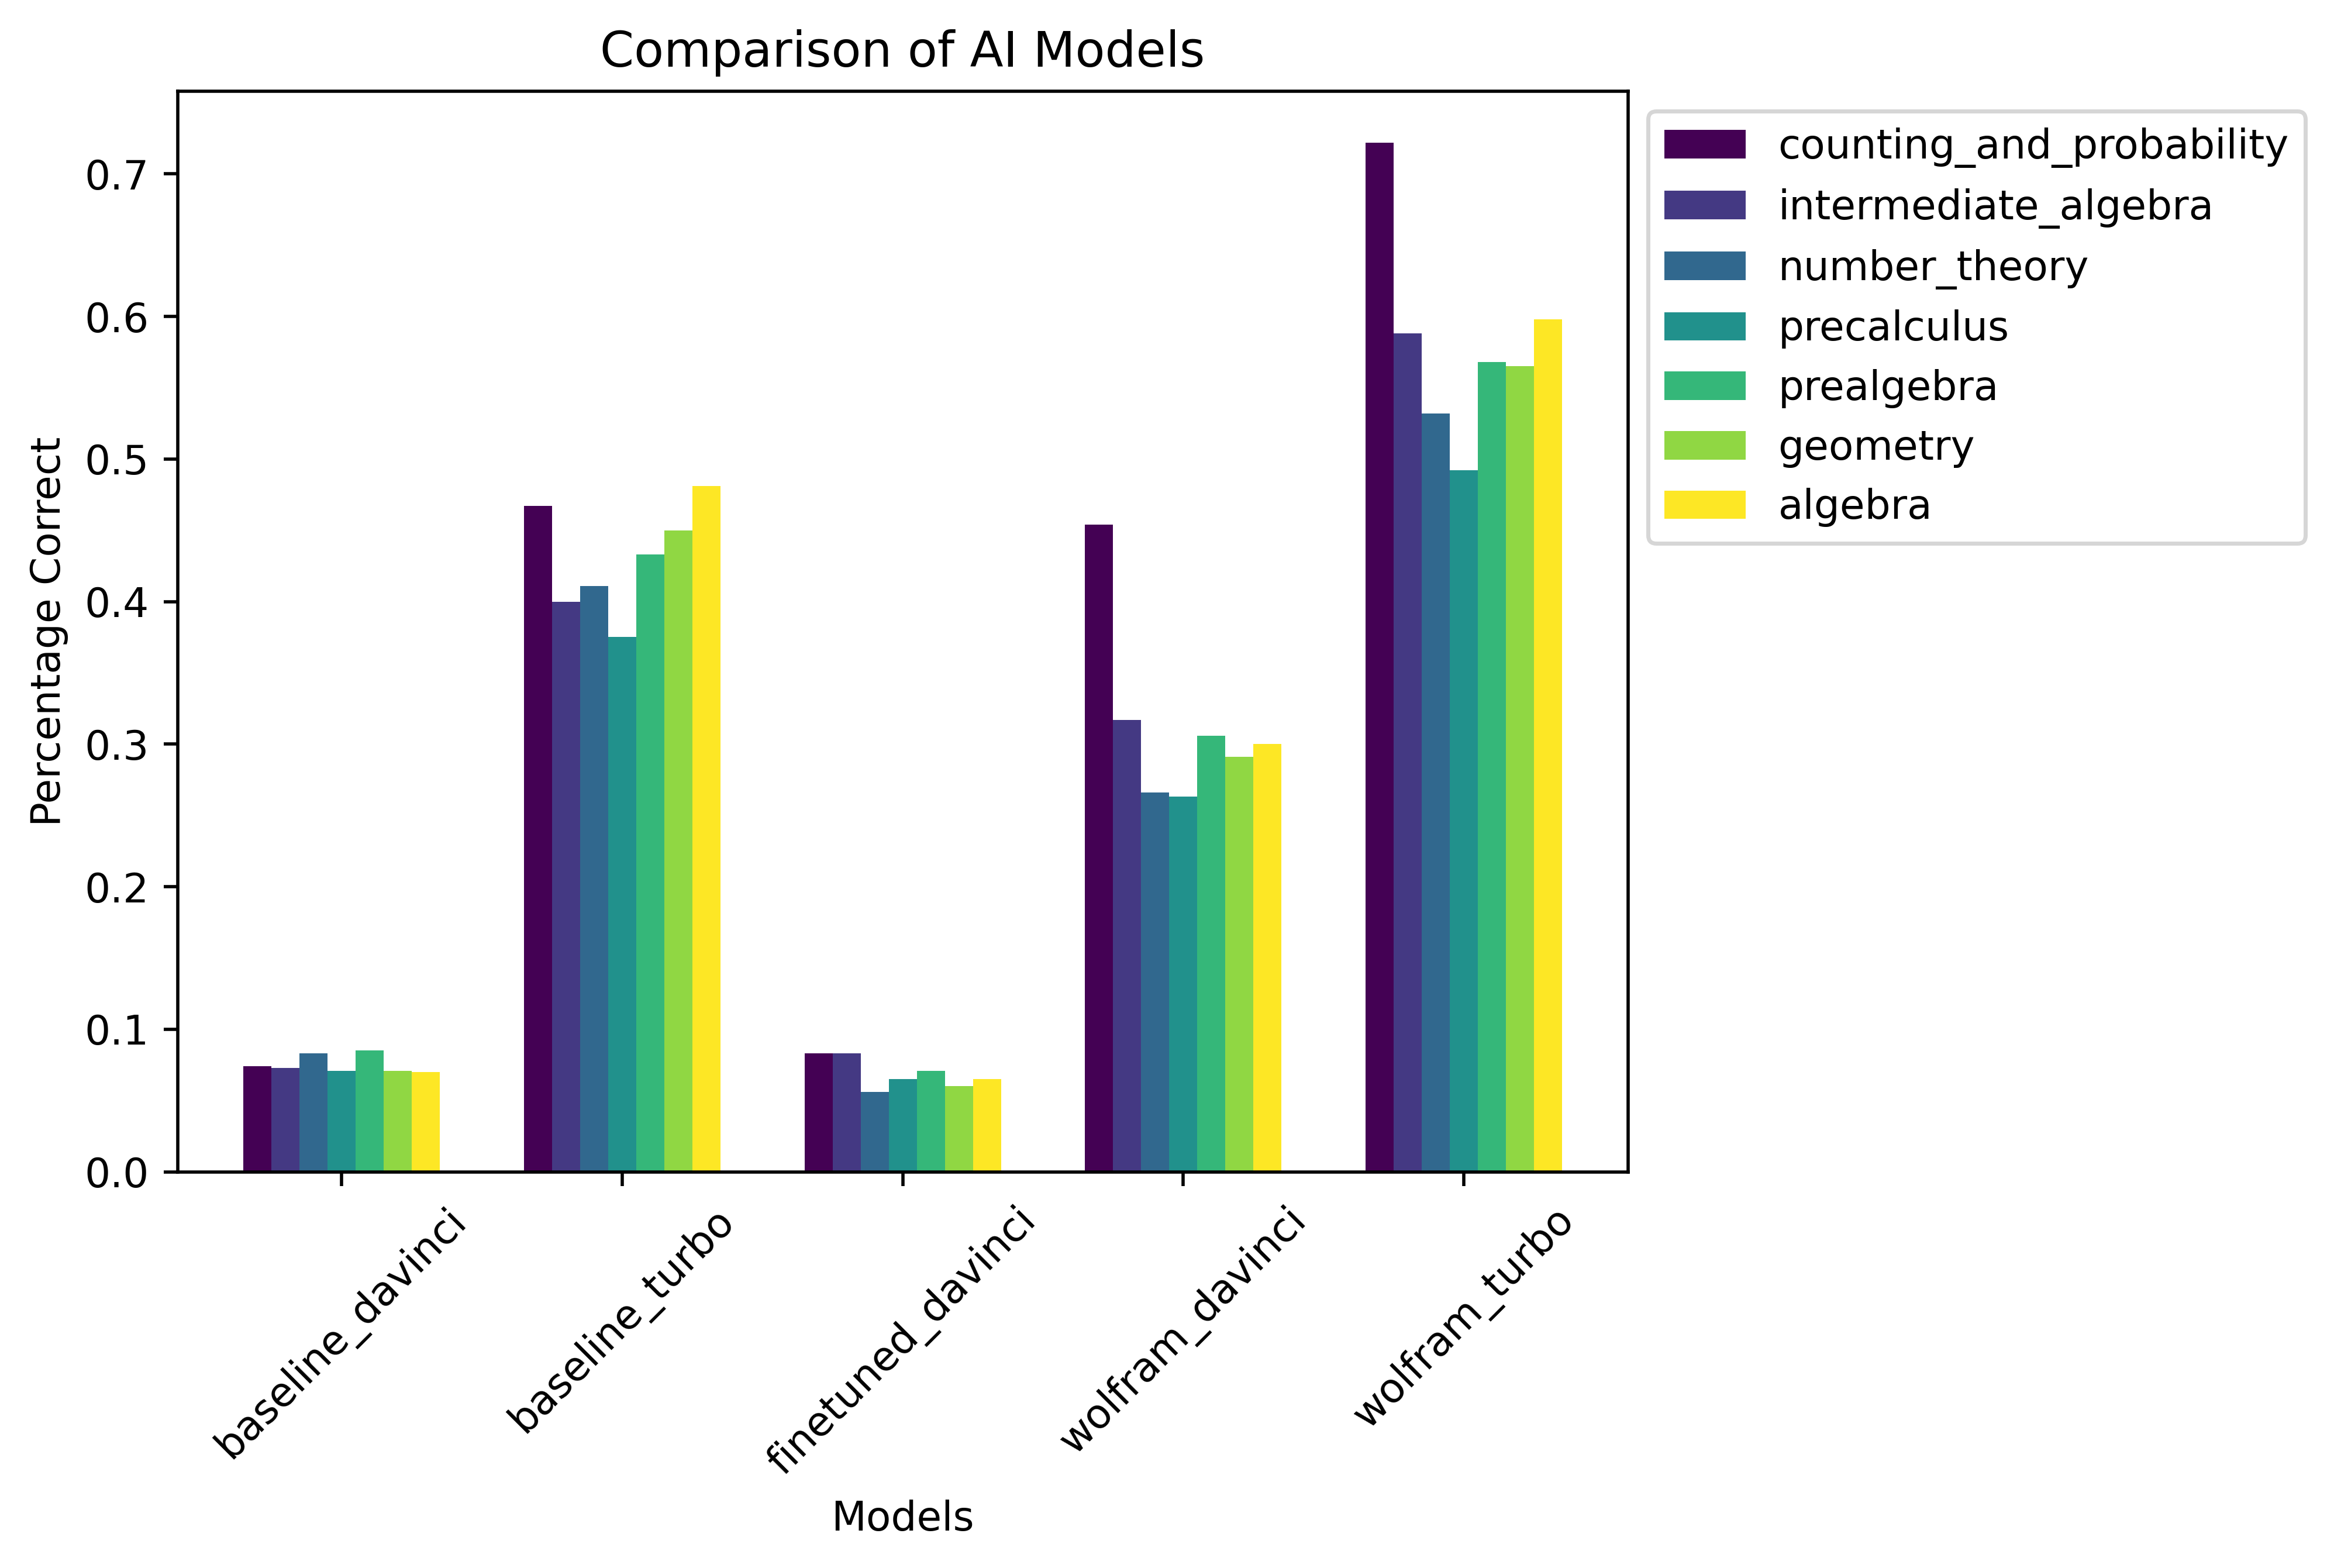

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['baseline_davinci', 'baseline_turbo', 'finetuned_davinci', 'wolfram_davinci', 'wolfram_turbo']

categories = ['counting_and_probability', 'intermediate_algebra', 'number_theory', 'precalculus', 'prealgebra', 'geometry', 'algebra']

data = [
    [0.074, 0.073, 0.083, 0.071, 0.085, 0.071, 0.070],   # baseline-davinci
    [0.467, 0.400, 0.411, 0.375, 0.433, 0.450, 0.481],   # baseline-turbo
    [0.083, 0.083, 0.056, 0.065, 0.071, 0.060, 0.065],   # finetuned-davinci
    [0.454, 0.317, 0.266, 0.263, 0.306, 0.291, 0.300],   # wolfram-davinci
    [0.722, 0.588, 0.532, 0.492, 0.568, 0.565, 0.598]    # wolfram-turbo
]

bar_width = 0.1
x = np.arange(len(models))

fig, ax = plt.subplots(dpi=500)

colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

# Plot the data
for i, (category, color) in enumerate(zip(categories, colors)):
    ax.bar(x + i * bar_width, [row[i] for row in data], bar_width, label=category, color=color)

# Customize the chart
ax.set_xlabel('Models')
ax.set_ylabel('Percentage Correct')
ax.set_title('Comparison of AI Models')
ax.set_xticks(x + (bar_width * (len(categories) - 1) / 2))
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the chart
plt.show()
